### Predicting Solana Price with Python and Machine Learning using XGBoost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

# Load the dataset
data = pd.read_csv('solana_2020-04-09_2024-10-28.csv')
data['Start'] = pd.to_datetime(data['Start'])
data.set_index('Start', inplace=True)

# Feature Engineering: Adding lagged features and rolling statistics
target = 'Close'
lags = [1, 7, 14, 30]
for lag in lags:
    data[f'{target}_lag_{lag}'] = data[target].shift(lag)



In [3]:
# Rolling statistics
data['rolling_mean_7'] = data[target].rolling(window=7).mean()
data['rolling_std_7'] = data[target].rolling(window=7).std()
data['rolling_mean_30'] = data[target].rolling(window=30).mean()
data['rolling_std_30'] = data[target].rolling(window=30).std()

# Drop NaN values created by lagging and rolling windows
data.dropna(inplace=True)


In [4]:
data.head()

,End,Open,High,Low,Close,Volume,Market Cap,Close_lag_1,Close_lag_7,Close_lag_14,Close_lag_30,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_std_30
Start,,,,,,,,,,,,,,,
2024-09-27,2024-09-28,119.799414,124.140225,118.865248,121.675224,1.263483e+10,5.688662e+10,121.117407,110.474561,111.991366,135.633441,115.580646,6.839136,118.213354,8.317320
2024-09-26,2024-09-27,114.437172,121.695113,113.373034,119.845513,9.463334e+09,5.519376e+10,121.675224,105.629587,107.078708,131.122418,117.611493,5.337568,117.837458,7.960977
2024-09-25,2024-09-26,117.547333,118.461610,113.744912,114.278060,1.074327e+10,5.447172e+10,119.845513,108.374884,107.505628,126.424915,118.454804,3.910593,117.432562,7.816747
2024-09-24,2024-09-25,111.683858,118.366405,110.594743,117.786849,9.481258e+09,5.311809e+10,114.278060,112.194110,110.647163,136.030681,119.253766,2.844232,116.824435,6.985416
2024-09-23,2024-09-24,111.212843,114.749692,110.132902,111.817993,8.934252e+09,5.229674e+10,117.786849,117.721940,111.265187,131.673528,118.410345,4.010458,116.162584,6.450108


In [5]:

target_column = 'Close'
X = data.drop(columns=[target_column])
y = data[target_column]

print("Data types before processing:")
print(X.dtypes)

X = X.copy()  # Create a copy to avoid warnings
categorical_columns = X.select_dtypes(include=['object']).columns
for col in categorical_columns:
    X[col] = X[col].astype('category')

# Modify the XGBoost model to handle categorical variables
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    enable_categorical=True  # Enable categorical feature support
)

Data types before processing:
End                 object
Open               float64
High               float64
Low                float64
Volume             float64
Market Cap         float64
Close_lag_1        float64
Close_lag_7        float64
Close_lag_14       float64
Close_lag_30       float64
rolling_mean_7     float64
rolling_std_7      float64
rolling_mean_30    float64
rolling_std_30     float64
dtype: object


In [6]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

param_grid = {
    'learning_rate': [0.005, 0.01, 0.05],
    'n_estimators': [1000, 2000, 3000],
    'max_depth': [6, 8, 10],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Set up TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)  # Adjust n_splits as needed

# Initialize the XGBoost model
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    enable_categorical=True  # Enable categorical feature support if using categorical features
)

# Hyperparameter tuning with RandomizedSearchCV and TimeSeriesSplit
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=1,
    n_jobs=-1
)
# Fit the model
random_search.fit(X, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=True,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=Non...
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'learning_rate': [0.005, 0.01, 0.05],
                                        'max_depth': [6, 8, 10],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [1000, 2000, 3000],
                                        'subsample': [0.8, 0.9, 1.0]},
                   scoring='neg_mean_squared_error', verbose=1)

In [7]:
# Get the best model from the search
best_xgb_model = random_search.best_estimator_

# Make predictions on the entire dataset for visualization purposes
y_pred = best_xgb_model.predict(X)

# Evaluate the model on the entire dataset
final_rmse = np.sqrt(mean_squared_error(y, y_pred))
final_mae = mean_absolute_error(y, y_pred)
print(f'Final RMSE: {final_rmse}, Final MAE: {final_mae}')





Final RMSE: 0.2724167665750418, Final MAE: 0.18355534339562493


In [8]:
from sklearn.metrics import r2_score

# Calculate R-squared
r2 = r2_score(y, y_pred)

# Convert to percentage
r2_percentage = r2 * 100

# Print all metrics including R-squared
print(f'Final RMSE: {final_rmse:.4f}')
print(f'Final MAE: {final_mae:.4f}')
print(f'R-squared: {r2:.4f}')
print(f'R-squared Percentage: {r2_percentage:.2f}%')

# You can also get the R-squared from cross-validation results
cv_r2 = random_search.best_score_  # This will be negative MSE from your current scoring
print(f'Cross-validation R-squared: {cv_r2:.4f}')

# Optional: Create a dictionary of all metrics
metrics = {
    'RMSE': final_rmse,
    'MAE': final_mae,
    'R-squared': r2,
    'R-squared Percentage': r2_percentage,
    'Cross-validation Score': cv_r2
}

# Print detailed metrics
print("\nDetailed Model Performance Metrics:")
for metric, value in metrics.items():
    if metric == 'R-squared Percentage':
        print(f'{metric}: {value:.2f}%')
    else:
        print(f'{metric}: {value:.4f}')

Final RMSE: 0.2724
Final MAE: 0.1836
R-squared: 1.0000
R-squared Percentage: 100.00%
Cross-validation R-squared: -426.1354

Detailed Model Performance Metrics:
RMSE: 0.2724
MAE: 0.1836
R-squared: 1.0000
R-squared Percentage: 100.00%
Cross-validation Score: -426.1354


In [9]:
print("Number of samples:", X.shape[0])
print("Number of features:", X.shape[1])

Number of samples: 1633
Number of features: 14


In [10]:
# Print feature names
print("Feature columns:", list(X.columns))

# Check for time-related columns
time_related = [col for col in X.columns if any(t in col.lower() 
            for t in ['time', 'date', 'year', 'month', 'day'])]
print("Time-related columns:", time_related)

# Print first few rows of your data
print("\nFirst few rows of features:")
print(X.head())
print("\nFirst few rows of target:")
print(y.head())

Feature columns: ['End', 'Open', 'High', 'Low', 'Volume', 'Market Cap', 'Close_lag_1', 'Close_lag_7', 'Close_lag_14', 'Close_lag_30', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_30', 'rolling_std_30']
Time-related columns: []

First few rows of features:
                   End        Open        High         Low        Volume  \
Start                                                                      
2024-09-27  2024-09-28  119.799414  124.140225  118.865248  1.263483e+10   
2024-09-26  2024-09-27  114.437172  121.695113  113.373034  9.463334e+09   
2024-09-25  2024-09-26  117.547333  118.461610  113.744912  1.074327e+10   
2024-09-24  2024-09-25  111.683858  118.366405  110.594743  9.481258e+09   
2024-09-23  2024-09-24  111.212843  114.749692  110.132902  8.934252e+09   

              Market Cap  Close_lag_1  Close_lag_7  Close_lag_14  \
Start                                                              
2024-09-27  5.688662e+10   121.117407   110.474561    111.991366   
202

In [11]:
# Check target variable distribution
print("\nTarget variable statistics:")
print(y.describe())

# Ensure X and y only contain numeric data for correlation calculation
X_numeric = X.select_dtypes(include=[np.number])
y_numeric = pd.to_numeric(y, errors='coerce')  # Convert y to numeric, handling errors if needed

# Check for high correlation with the target variable
correlations = X_numeric.corrwith(y_numeric)
high_corr = correlations[abs(correlations) > 0.95]

if not high_corr.empty:
    print("\nFeatures with very high correlation to the target variable:")
    print(high_corr)
else:
    print("\nNo features with very high correlation to the target variable.")



Target variable statistics:
count    1633.000000
mean       47.267467
std        47.870387
min         0.402208
25%        11.556778
50%        25.064832
75%        80.812134
max       199.381758
Name: Close, dtype: float64

Features with very high correlation to the target variable:
Open               0.997335
High               0.998936
Low                0.998584
Market Cap         0.966669
Close_lag_1        0.997316
Close_lag_7        0.979589
Close_lag_14       0.958181
rolling_mean_7     0.994661
rolling_mean_30    0.970025
dtype: float64


In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
import numpy as np

# Define scoring functions for MAE, MSE, and RMSE
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False)

# Perform cross-validation for each metric
mae_scores = cross_val_score(xgb_model, X, y, cv=5, scoring=mae_scorer)
mse_scores = cross_val_score(xgb_model, X, y, cv=5, scoring=mse_scorer)
rmse_scores = cross_val_score(xgb_model, X, y, cv=5, scoring=rmse_scorer)

# Print the cross-validation results
print("\nCross-validation Mean Absolute Error (MAE):", -mae_scores.mean())
print("Mean CV MAE:", -mae_scores.mean())
print("CV MAE std:", mae_scores.std())

print("\nCross-validation Mean Squared Error (MSE):", -mse_scores.mean())
print("Mean CV MSE:", -mse_scores.mean())
print("CV MSE std:", mse_scores.std())

print("\nCross-validation Root Mean Squared Error (RMSE):", -rmse_scores.mean())
print("Mean CV RMSE:", -rmse_scores.mean())
print("CV RMSE std:", rmse_scores.std())



Cross-validation Mean Absolute Error (MAE): 16.479455322983092
Mean CV MAE: 16.479455322983092
CV MAE std: 15.761844486244243

Cross-validation Mean Squared Error (MSE): 638.3766757657304
Mean CV MSE: 638.3766757657304
CV MSE std: 932.226711472995

Cross-validation Root Mean Squared Error (RMSE): 19.135572356548522
Mean CV RMSE: 19.135572356548522
CV RMSE std: 16.4986831702723


In [13]:
# More robust evaluation
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
xgb_model.fit(X_train, y_train)

# Predict on test set
y_test_pred = xgb_model.predict(X_test)

# Calculate metrics on test set
test_r2 = r2_score(y_test, y_test_pred)
print(f"\nTest set R²: {test_r2:.4f} ({test_r2*100:.2f}%)")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 most important features:")
print(feature_importance.head(10))


Test set R²: 0.9516 (95.16%)

Top 10 most important features:
            feature  importance
2              High    0.560123
1              Open    0.353688
6       Close_lag_1    0.067040
3               Low    0.010764
5        Market Cap    0.007052
0               End    0.000648
12  rolling_mean_30    0.000592
10   rolling_mean_7    0.000078
4            Volume    0.000012
11    rolling_std_7    0.000004


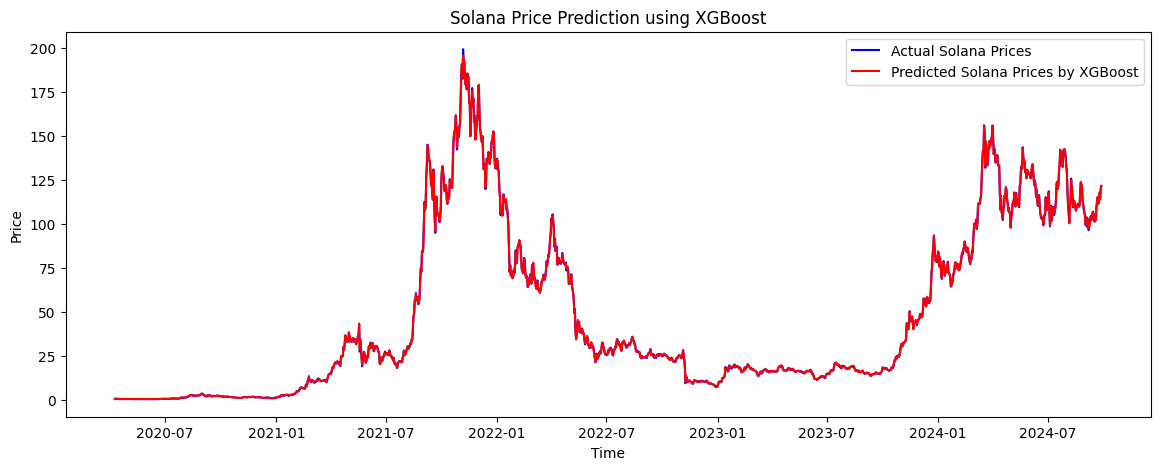

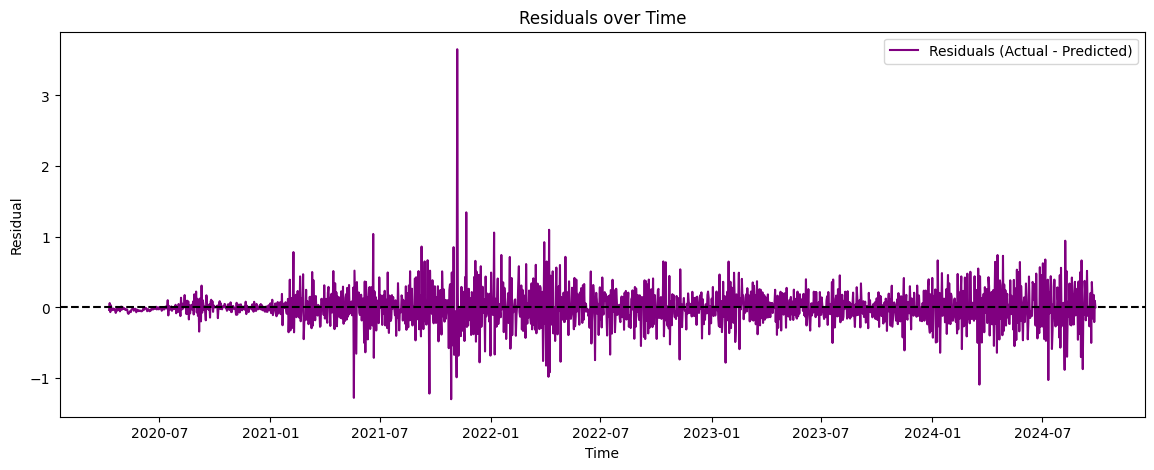

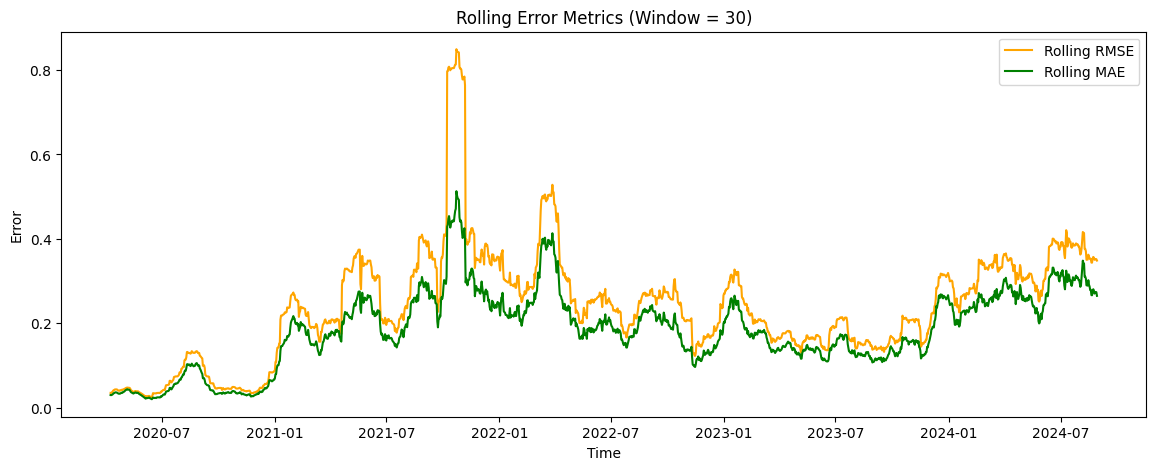

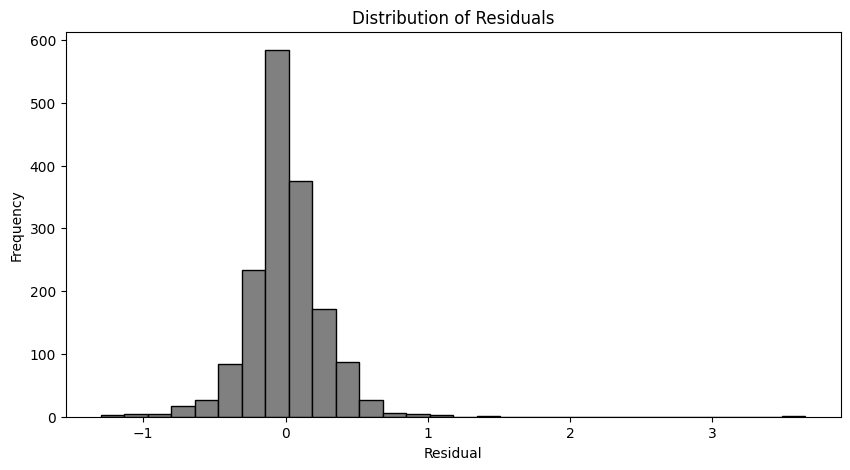

C:\Users\Student\AppData\Local\Temp\ipykernel_43092\1785558640.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, color='red')


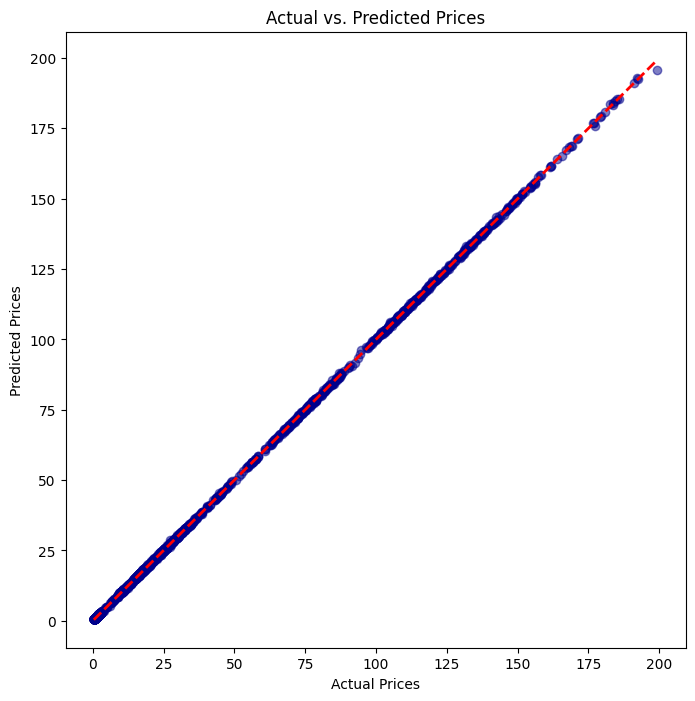

In [14]:

# Visualization Section

# 1. Predictions vs. Actuals Line Plot
plt.figure(figsize=(14, 5))
plt.plot(data.index, y, color='blue', label='Actual Solana Prices')
plt.plot(data.index, y_pred, color='red', label='Predicted Solana Prices by XGBoost')
plt.title('Solana Price Prediction using XGBoost')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# 2. Residual Plot
# Calculate residuals
residuals = y - y_pred

plt.figure(figsize=(14, 5))
plt.plot(data.index, residuals, color='purple', label='Residuals (Actual - Predicted)')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals over Time')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.legend()
plt.show()

# 3. Rolling RMSE or MAE Plot
# Define window size (e.g., 30 days)
rolling_window = 30

# Calculate rolling RMSE
rolling_rmse = pd.Series((y - y_pred) ** 2).rolling(window=rolling_window).mean().apply(np.sqrt)
rolling_mae = pd.Series(np.abs(y - y_pred)).rolling(window=rolling_window).mean()

plt.figure(figsize=(14, 5))
plt.plot(data.index, rolling_rmse, color='orange', label='Rolling RMSE')
plt.plot(data.index, rolling_mae, color='green', label='Rolling MAE')
plt.title(f'Rolling Error Metrics (Window = {rolling_window})')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend()
plt.show()

# 4. Error Distribution (Histogram)
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, color='grey', edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

# 5. Actual vs. Predicted Scatter Plot
plt.figure(figsize=(8, 8))
plt.scatter(y, y_pred, color='darkblue', alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, color='red')
plt.title('Actual vs. Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()


In [2]:
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt


In [30]:
# Load Solana data from CSV
solana_data = pd.read_csv('solana_2020-04-09_2024-10-28.csv', parse_dates=['Start'])
solana_data.set_index('Start', inplace=True)

In [34]:
# Download BTC historical data using yfinance
btc_data = yf.download('BTC-GBP', start='2020-04-09', end='2024-04-10')['Adj Close']
btc_data = btc_data.rename('BTC-GBP')

[*********************100%%**********************]  1 of 1 completed


In [35]:
# Merge BTC and Solana data on date
crypto_data = pd.concat([btc_data, solana_data['Close']], axis=1)
crypto_data.columns = ['BTC-GBP', 'SOL-GBP']


In [36]:
# Display the first few rows of merged data
print(crypto_data.head())


                BTC-GBP   SOL-GBP
2020-04-09  5863.468262  0.531438
2020-04-10  5514.893066  0.729890
2020-04-11  5510.628418  0.598990
2020-04-12  5594.810059  0.691138
2020-04-13  5465.358887  0.598641


In [37]:
# Calculate daily returns
daily_returns = crypto_data.pct_change().dropna()

# Display the first few rows of daily returns
print(daily_returns.head())

             BTC-GBP   SOL-GBP
2020-04-10 -0.059449  0.373424
2020-04-11 -0.000773 -0.179342
2020-04-12  0.015276  0.153839
2020-04-13 -0.023138 -0.133834
2020-04-14 -0.008375 -0.140564


C:\Users\Student\AppData\Local\Temp\ipykernel_10036\3898951582.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = crypto_data.pct_change().dropna()


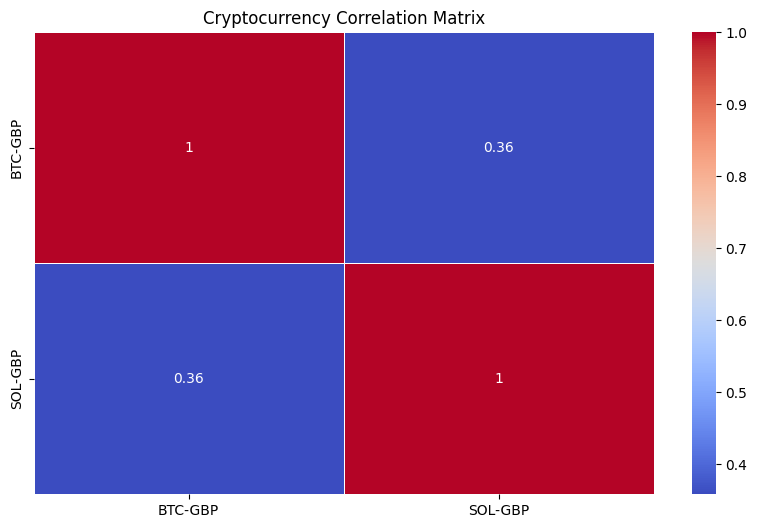

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
correlation_matrix = daily_returns.corr()

# Plot a heatmap to visualize correlations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Cryptocurrency Correlation Matrix')
plt.show()

In [39]:
# Let's define a threshold for significant negative correlation
threshold = -0.65

# Check if BTC and ETH have strong negative correlation
btc_sol_corr = correlation_matrix.loc['BTC-GBP', 'SOL-GBP']
print(f"Correlation between BTC and SOL: {btc_sol_corr}")

if btc_sol_corr < threshold:
    print("Significant negative correlation found. Consider pairs trading.")
else:
    print("No significant negative correlation found. Strategy not suitable.")

Correlation between BTC and SOL: 0.3585983617737395
No significant negative correlation found. Strategy not suitable.


In [40]:
# Backtesting the Strategy
# Define buy and sell signals based on correlation
def trade_signal(row):
    if row['BTC-GBP'] > 0.01 and row['SOL-GBP'] < 0.5:
        return 'Buy SOL, Sell BTC'
    elif row['BTC-GBP'] < -0.01 and row['SOL-GBP'] > 0.5:
        return 'Buy BTC, Sell SOL'
    else:
        return 'No trade'
    
''' A function that generates trading signals based on a threshold of 1% daily return. 
If Bitcoin rises by more than 1% and Solana falls by more than 5%, 
we generate a buy/sell signal (and vice versa).
'''
# Apply the trading signals
daily_returns['Trade Signal'] = daily_returns.apply(trade_signal, axis=1)

# Display the first few trade signals
print(daily_returns[['BTC-GBP', 'SOL-GBP', 'Trade Signal']].head())

             BTC-GBP   SOL-GBP       Trade Signal
2020-04-10 -0.059449  0.373424           No trade
2020-04-11 -0.000773 -0.179342           No trade
2020-04-12  0.015276  0.153839  Buy SOL, Sell BTC
2020-04-13 -0.023138 -0.133834           No trade
2020-04-14 -0.008375 -0.140564           No trade


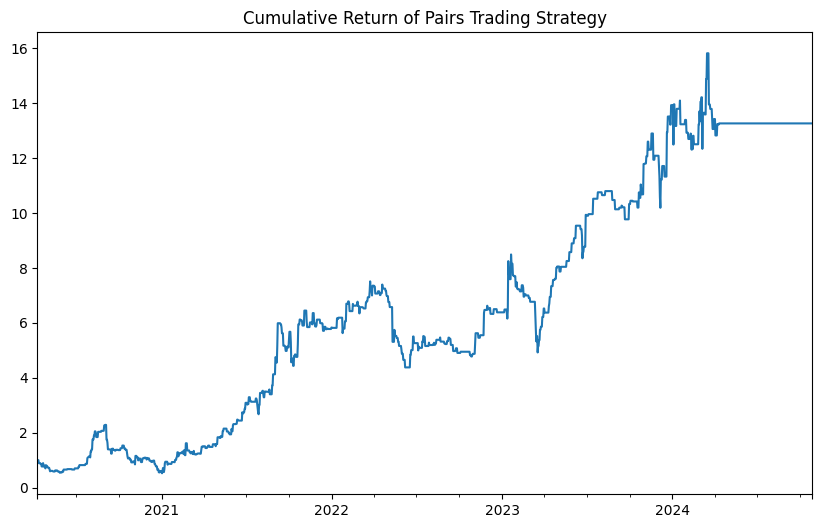

In [42]:
# Initialise portfolio returns
portfolio_returns = []

# Simulate trading returns based on signals
for i in range(1, len(daily_returns)):
    if daily_returns['Trade Signal'].iloc[i-1] == 'Buy SOL, Sell BTC':
        portfolio_return = daily_returns['SOL-GBP'].iloc[i] - daily_returns['BTC-GBP'].iloc[i]
    elif daily_returns['Trade Signal'].iloc[i-1] == 'Buy BTC, Sell SOL':
        portfolio_return = daily_returns['BTC-GBP'].iloc[i] - daily_returns['SOL-GBP'].iloc[i]
    else:
        portfolio_return = 0
    portfolio_returns.append(portfolio_return)

# Add portfolio returns to dataframe
daily_returns['Portfolio Return'] = [0] + portfolio_returns

# Calculate cumulative returns
daily_returns['Cumulative Return'] = (1 + daily_returns['Portfolio Return']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(10, 6))
daily_returns['Cumulative Return'].plot()
plt.title('Cumulative Return of Pairs Trading Strategy')
plt.show()
